In [1]:
%matplotlib inline

import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [87]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 30 + 30))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 60 + 60)) # + wave 2
    series += 0.02 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

n_steps = 100
pred_steps = 20
series = generate_time_series(10000, n_steps + pred_steps)

X_train, Y_train = series[:7000, :n_steps], series[:7000, -pred_steps:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -pred_steps:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -pred_steps:, 0]

Example of generated sequence

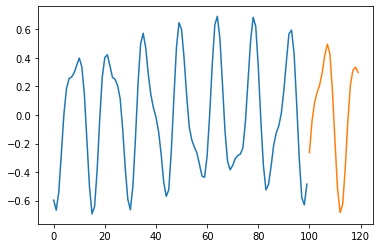

In [88]:
plt.plot(np.arange(n_steps), X_train[0])
plt.plot(np.arange(n_steps, n_steps + pred_steps), Y_train[0])

Great explanation of simplified [TCN](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb).

![](https://github.com/JEddy92/TimeSeries_Seq2Seq/raw/190fe87a9ea48bc5096b6417b7cb769aaa8887cf/notebooks/images/WaveNet_dilatedconv.png)

In [96]:
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(6)] 

history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last pred_steps time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':pred_steps})(x)

model = Model(history_seq, pred_seq_train)
model.summary()

model.compile(Adam(), loss='mean_absolute_error')

history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, None, 32)          96        
_________________________________________________________________
conv1d_29 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_30 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_31 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_32 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_33 (Conv1D)           (None, None, 32)          2080

Let's look at predictions

In [97]:
pred = model.predict(X_test)

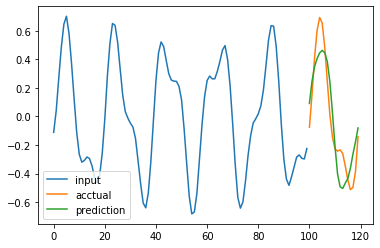

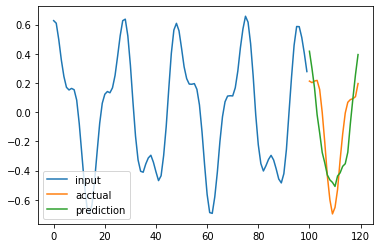

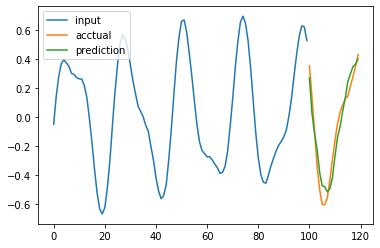

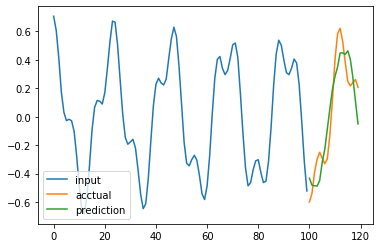

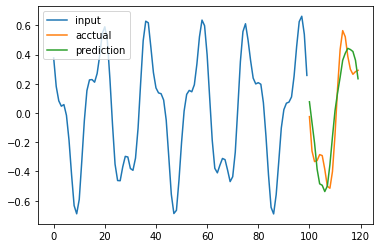

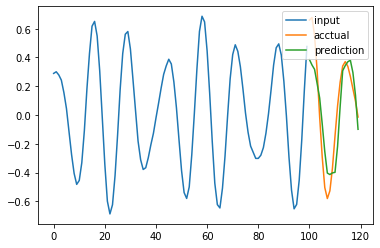

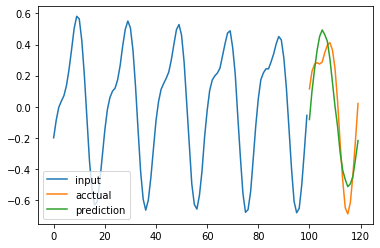

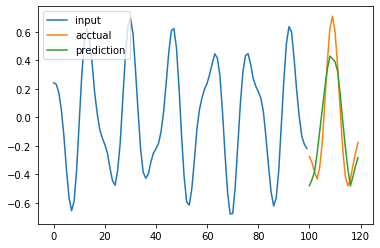

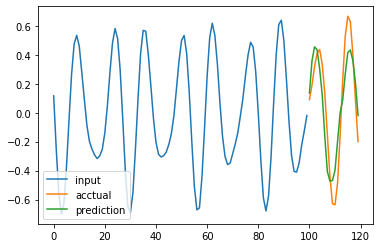

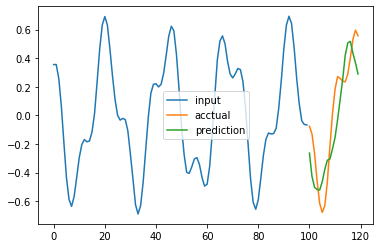

In [98]:
for i in range(10):
    plt.plot(np.arange(n_steps), X_test[i], label='input')
    plt.plot(np.arange(n_steps, n_steps + pred_steps), Y_test[i], label='acctual')
    plt.plot(np.arange(n_steps, n_steps + pred_steps), pred[i], label='prediction')
    plt.legend()
    plt.show()